### IMPORT + 기본모델설정 + Defensive Distillation

In [1]:
#기본 IMPORT
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.utils import save_image
import torchvision.models as models
from torch.autograd import Variable

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE

#TensorBoard 사용하기
from torch.utils.tensorboard import SummaryWriter
from IPython.core.interactiveshell import InteractiveShell
writer = SummaryWriter()
InteractiveShell.ast_node_interactivity="all"

<Figure size 1000x100 with 0 Axes>

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 9')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 9')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 1')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 4')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 9')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 5')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 8')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 1')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 7')

<Axes: >

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Class: 0')

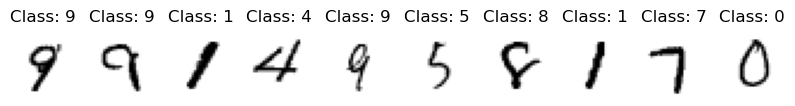

In [2]:
#Device 및 기본 설정 + 데이터셋 받아오기(MNIST)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=32
EPOCHS=10

train_dataset = datasets.MNIST(root='data/MNIST',train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data/MNIST',train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE, shuffle=False)

for (X_train, y_train) in train_loader:
    # print('X_train:', X_train.size(),'type:',X_train.type())
    # print('y_train:',y_train.size(), 'type:',y_train.type())
    pass
                                    
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize)) #10개 plot하기 위한 figure 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1) # plot.subplot(rows, columns, index)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [3]:
# Distillation Teacher Network (pre-trained ResNet)
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

teacher_model = models.resnet50(weights=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features,10)
teacher_model = teacher_model.to(DEVICE)

# Student Network (Distillation Target)
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        return F.log_softmax(self.fc2(x), dim=1)

student_model = StudentNet().to(DEVICE)
optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

c:\Users\user\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Distillation Training
def distill_train(teacher_model, student_model, train_loader, optimizer, temperature=5.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            with torch.no_grad():
                soft_labels = F.softmax(teacher_model(data) / temperature, dim=1)
            output = student_model(data)
            loss = alpha * criterion(output, target) + (1 - alpha) * F.kl_div(
                F.log_softmax(output / temperature, dim=1), soft_labels, reduction="batchmean"
            ) * (temperature ** 2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Distillation Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}")

distill_train(teacher_model, student_model, train_loader, optimizer)
print("Distillation Completed")

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead